# Clasificador de persuación

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from collections import Counter
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
# Número de GPUs disponibles. Usar 0 para modo CPU.
ngpu = 1

# Fuente de la cual queremos obtener los datos
source = 'corenlp'

# Semilla a usar en los generadores de números aleatorios
SEED = 42
# SEED = random.randint(1, 10000) # En caso de requerir más resultados
random.seed(SEED)
torch.manual_seed(SEED)
print(SEED)

42


In [3]:
# Decide si queremos correr en gpu o cpu
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

## Descripción de las Categorías

### Categoría Cognitiva

#### Subcategorías:

1. **Construcción del emisor/candidato (C1):** el candidato se coloca como referente principal del acto discursivo para exaltar sus cualidades personales y erigirse, a los ojos de sus interlocutores, como un líder en quien es adecuado confiar para el desarrollo de acciones de gobierno a favor de la sociedad; esto lo lleva a cabo mediante realizaciones léxicas de la primera persona, en singular o plural, y formas flexivas de verbos y posesivos para referirse a sí mismo, ya sea como individuo o como miembro de una colectividad. Para el caso de la campaña presidencial que nos ocupa, las cualidades del candidato emitidas por un tercero en el marco de una tarea proselitista, quedarán incluidas en esta categoría, ya que contribuyen a construir la imagen positiva del contendiente.

2. **Promesa de campaña (C2):** a través de piezas discursivas, orales o escritas, el candidato oferta, destaca o compromete acciones que proyecta convertir en políticas públicas a favor de la población, si obtiene el triunfo en las urnas, con lo que implícitamente solicita el voto ciudadano que lo llevaría al poder.

### Categoría Emocional

#### Subcategorías:

3. **Construcción del adversario (E1):** el mensaje es dirigido a su contraparte en la contienda electoral y está construido a manera de réplica y puede usar diferentes figuras retóricas (metáfora, ironía, metonimia) para conformar en el receptor una imagen determinada del adversario, que esencialmente tiene finalidad de descrédito.

4. **Exageración de la información (E2):** se destacan los datos favorables a los fines persuasivos, con el objetivo de crear una idea positiva en la mente del receptor referente al tema del que se habla, o incluso negativa respecto de información relativa al adversario; el persuasor desfigura el sentido original del acontecimiento, nos dice Roiz (1994), mediante códigos diferentes: humorístico, burlesco, cínico, entre otros.

5. **Recurso retórico (E3):** son variables basadas en figuras retóricas (metáfora, ironía, hipérbole, personificación, pleonasmo, perífrasis) que pueden fortalecer el efecto persuasivo, de acuerdo con Reardon (1991).

6. **Apelación al miedo (E4):** el candidato emite mensajes dentro de su alocución que pretenden provocar sentimientos de aprensión, desasosiego o preocupación con respecto al adversario o a sus propuestas. 

### Categoría Volitiva

#### Subcategoría:

7. **Llamado al voto (V1):** el emisor del mensaje hace una invitación directa al ciudadano para que apoye su proyecto político el día de la elección al depositar el sufragio a su favor.


In [4]:
ix_to_cat = ['C1', 'C2', 'E1', 'E2', 'E3', 'E4','V1']
cat_to_ix = { cat: ix for ix, cat in enumerate(ix_to_cat) }

num_cat = len(ix_to_cat) # Tamaño de salida de la red

cat_to_ix

{'C1': 0, 'C2': 1, 'E1': 2, 'E2': 3, 'E3': 4, 'E4': 5, 'V1': 6}

## Obtención de datos

### Vocabulario

In [5]:
ix_to_w = []
with open(f'./../Embeddings/word_labels_{source}.txt', 'r', encoding='utf-8') as f:
    ix_to_w = f.read().splitlines()
    
w_to_ix = { w: ix for ix, w in enumerate(ix_to_w) }

tam_vocab = len(ix_to_w)

ix_to_w[:5]

[',', 'de', 'que', 'la', 'a']

### Enunciados

In [6]:
sentences = []
with open(f'./Corpus/Train/sentences-{source}.txt', 'r', encoding='utf-8') as f:
    sentences = [s.split() for s in f.read().splitlines()]

[' '.join(s) for s in sentences[:5]]

['El candidato de la coalición Todos por México se comprometió a estar con la población guerrerense en las buenas y en las malas .',
 'Respecto a las zonas económicas especiales , el candidato de la coalición Todos por México mencionó que éstas deben ser aprovechadas como una especie de laboratorio , que genere recimiento a la medida en el norte y en el sur de la República mexicana .',
 'Se compromete a abrir escuelas y guarderías de tiempo completo .',
 '" Aquí están las mujeres y hombres priistas que son todo terreno , los que van a hacer posible que Pepe Meade sea presidente ; un hombre preparado , capaz y con experiencia para enfrentar la gobernabilidad de un país como México .',
 'Y , quinto , Fiscalías General y Anticorrupción absolutamente autónomas e independientes , que puedan juzgar y perseguir a cualquier funcionario , incluyendo a el Presidente de la República .']

### Categorías persuasivas por enunciado

In [7]:
categorias_sents = []
with open('./Corpus/Train/sentences-tags.txt', 'r', encoding='utf-8') as f:
    categorias_sents = [t.split() for t in f.read().splitlines()]

categorias_sents[:5]

[['C2'], ['NA'], ['C2'], ['E3', 'C1'], ['NA']]

## Preparar datos para Red Neuronal

In [8]:
BOS = '<BOS>'
EOS = '<EOS>'
UNK = '<UNK>'

ixBOS = w_to_ix[BOS]
ixEOS = w_to_ix[EOS]
ixUNK = w_to_ix[UNK]

### Palabras a índices numéricos

In [9]:
def unk_w_to_ix(w):
    try:
        return w_to_ix[w]
    except KeyError:
        return ixUNK

In [10]:
X = [
    # Convierto las palabras (en minúsculas) a índices
    [ unk_w_to_ix(w.lower()) for w in sent ] 
    for sent in sentences
]

[str(x) for x in X[:5]]

['[5, 26, 1, 3, 38, 33, 16, 20, 11, 203, 4, 249, 14, 3, 441, 7473, 8, 17, 1972, 7, 8, 17, 1929, 6]',
 '[1416, 4, 17, 1183, 3052, 4901, 0, 5, 26, 1, 3, 38, 33, 16, 20, 284, 2, 3056, 909, 89, 7473, 28, 24, 3487, 1, 7473, 0, 2, 2709, 7473, 4, 3, 1098, 8, 5, 563, 7, 8, 5, 668, 1, 3, 71, 645, 6]',
 '[11, 1237, 4, 2807, 560, 7, 602, 1, 170, 431, 6]',
 '[10, 195, 70, 17, 114, 7, 540, 881, 2, 57, 66, 1522, 0, 9, 2, 84, 4, 93, 769, 2, 1688, 34, 145, 53, 105, 19, 776, 1943, 0, 2716, 7, 14, 854, 13, 675, 3, 4741, 1, 19, 32, 28, 20, 6]',
 '[7, 0, 2181, 0, 4940, 383, 7, 2142, 797, 4941, 185, 1968, 0, 2, 541, 3402, 7, 2806, 4, 942, 1466, 0, 2464, 4, 5, 53, 1, 3, 71, 6]']

### Categorías a índices numéricos

In [11]:
Y = [[0 for _ in ix_to_cat] for c in categorias_sents]

for i, cats_sents in enumerate(categorias_sents):
    for cat in cats_sents:
        try:
            ix_cat = cat_to_ix[cat]
            Y[i][ix_cat] = 1 # Pongo 1 si encuentro la categoría
        except KeyError:
            pass

Y[:5]

[[0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0]]

In [12]:
X = [np.asarray(x, dtype=np.long) for x in X]
Y = [np.asarray(y, dtype=np.float) for y in Y]

### Crear datos de entrenamiento y validación

In [13]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15)

### Mover datos a tensores en gpu

In [14]:
def np_to_long_tensor(list_of_lists):
    return [
        # La capa de entrada debe ser un tensor long
        torch.from_numpy(l).long().to(device)
        for l in list_of_lists
    ]

def np_to_float_tensor(list_of_lists):
    return [
        # La capa de salida debe ser un tensor float
        torch.from_numpy(l).float().to(device) 
        for l in list_of_lists
    ]

In [15]:
X_train = np_to_long_tensor(X_train)
Y_train = np_to_float_tensor(Y_train)

X_val = np_to_long_tensor(X_val)
Y_val = np_to_float_tensor(Y_val)

N_train = len(X_train)
N_val = len(X_val)

In [16]:
print(f'Tamaño del corpus de entrenamiento: {N_train}')
print(f'Tamaño del corpus de validación: {N_val}')

Tamaño del corpus de entrenamiento: 119
Tamaño del corpus de validación: 21


## Descripción del modelo

### Capa de embedding

### Capa LSTM

### Capa de salida



In [17]:
# Dimensiones de la red neuronal
D_in = tam_vocab
D_emb = 64
D_lstm = 32
D_out = num_cat

# Épocas de entrenamiento
epochs = 75

# Learning rate
lr =  0.001

In [18]:
class PersuasionLSTM(nn.Module):
    def __init__(self, D_in, D_emb, D_lstm, D_out):
        super(PersuasionLSTM, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=D_in, embedding_dim=D_emb)#, padding_idx=0)
        # self.dropout = nn.Dropout(p=0.2)
        self.lstm = nn.LSTM(input_size=D_emb, hidden_size=D_lstm)
        self.linear = nn.Linear(in_features=D_lstm, out_features=D_out)
        self.sig = nn.Sigmoid()
        

    def forward(self, sentence):
        T = len(sentence)
        embeddings = self.embedding(sentence).view(T, 1, -1)
        # embeddings = self.dropout(embeddings)
        lstm_out, (ht, ct) = self.lstm(embeddings)
        lstm_out = lstm_out.view(T, -1)
        preact_out = self.linear(lstm_out).view(T, -1)
        return self.sig(preact_out[-1])

In [19]:
persuasion = PersuasionLSTM(D_in, D_emb, D_lstm, D_out).to(device)
persuasion

PersuasionLSTM(
  (embedding): Embedding(7474, 64)
  (lstm): LSTM(64, 32)
  (linear): Linear(in_features=32, out_features=7, bias=True)
  (sig): Sigmoid()
)

Cargo los pesos de la capa de embedding del modelo aprendido en [lstm.ipynb](./../Embeddings/lstm.ipynb)

In [20]:
dir_path = './../Embeddings/modelsaves/'
filename = 'modelv2-corenlp-emb_64-lstm_32-seed_42069-epochs_299-best-val'
state_dict = torch.load(dir_path+filename)

persuasion.embedding.load_state_dict(
    {
      'weight' : state_dict['embedding.weight']   
    }
)

<All keys matched successfully>

Congelo la capa de embedding para que no aprenda más

In [21]:
persuasion.embedding.weight.requires_grad = False

In [22]:
criterion = nn.BCELoss()
criterion.to(device)
optimizer = torch.optim.Adam(
    [ 
        param for param in persuasion.parameters() 
        if param.requires_grad == True
    ], 
    lr=lr)

In [23]:
def hard_prob(y_hat, criterio_decision = 0.59):
    with torch.no_grad():
        pred = torch.gt(y_hat, 0.59)
        pred.type(torch.Float)
    return pred

def calc_mat_conf(y_hat, y_real):
    y_hat 

In [24]:
historial = {
    'train':{
        
    },
    'val':{
        
    },
}

In [25]:
%%time
train_loss_hist = np.zeros(epochs+1)
val_loss_hist = np.zeros(epochs+1)

train_loss_hist[-1] = np.inf
val_loss_hist[-1] = np.inf

best_eval_model = {}
best_train_model = {}

matrices_conf = {}

train_data = list(zip(X_train, Y_train))
val_data = list(zip(X_val, Y_val))

for epoch in tqdm(range(epochs)):
    
    # Entrenamiento
    persuasion.train()
    train_loss = 0
    random.shuffle(train_data)
    for x, y in train_data:
        # Limpiamos gradientes acumulados
        persuasion.zero_grad()

        # Forward
        out = persuasion(x)
     
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= N_train
    train_loss_hist[epoch] = train_loss
    
    # Validación
    persuasion.eval()
    val_loss = 0
    random.shuffle(val_data)
    for x, y in val_data:
        out = persuasion(x)     
        loss = criterion(out, y)
        val_loss += loss.item()
    val_loss /= N_val
    val_loss_hist[epoch] = val_loss
    
    if epoch%20 == 0:
#         tqdm.write(f'Epoch {epoch+1:3}.\ttrain_loss: {train_loss:2.6f}')
        tqdm.write(f'Epoch {epoch+1:3}.\ttrain_loss: {train_loss:2.6f}\tval_loss: {val_loss:2.6f}')
    if val_loss < val_loss_hist[epoch-1]:
        best_eval_model = persuasion.state_dict()
#     if val_loss < val_loss_hist[epoch-1]:
#         best_eval_model = model.state_dict()

train_loss_hist = train_loss_hist[:-1]
val_loss_hist = val_loss_hist[:-1]

Epoch   1.	train_loss: 0.527166	val_loss: 0.433900
Epoch  21.	train_loss: 0.057524	val_loss: 0.735924
Epoch  41.	train_loss: 0.010027	val_loss: 0.991322
Epoch  61.	train_loss: 0.002706	val_loss: 1.218909

Wall time: 1min 5s


In [26]:
len(train_loss_hist)

75

In [27]:
best_train_epoch = train_loss_hist.argmin()+1
best_val_epoch = val_loss_hist.argmin()+1

print(f'Mejor resultado en corpus de entrenamiento en época {best_train_epoch}')
print(f'Mejor resultado en corpus de validación en época {best_val_epoch}')

Mejor resultado en corpus de entrenamiento en época 75
Mejor resultado en corpus de validación en época 4


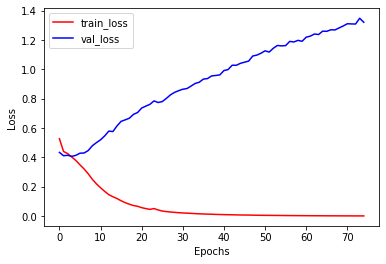

In [28]:
plt.figure()

plt.plot(train_loss_hist, color='red', label='train_loss')
plt.plot(val_loss_hist, color='blue', label='val_loss')
plt.legend()

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.savefig(f'./img/Loss-{source}-emb_{D_emb}-lstm_{D_lstm}-seed_{SEED}-epochs_{epochs}.png')

plt.show()

In [29]:
torch.save(
    persuasion.state_dict(), # El último
    f'./modelsaves/model-{source}-emb_{D_emb}-lstm_{D_lstm}-seed_{SEED}-epochs_{epochs}-last-trained'
)

In [30]:
torch.save(
    best_eval_model, 
    f'./modelsaves/model-{source}-emb_{D_emb}-lstm_{D_lstm}-seed_{SEED}-epochs_{best_val_epoch}-best-val'
)